# Visual Search using Cosine Similarity

### Data
We use a sample of the Category and Attribute Prediction Benchmark dataset (by DeepFashion) with 275 images. 

In [4]:
# Importing libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import scipy as sc

2.9.2


# Load Images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/

/content/drive


In [7]:
cd MyDrive/ADM_Notebooks/Data/assignment2

/content/drive/MyDrive/ADM_Notebooks/Data/assignment2


## Preprocessing images

Found [275] images


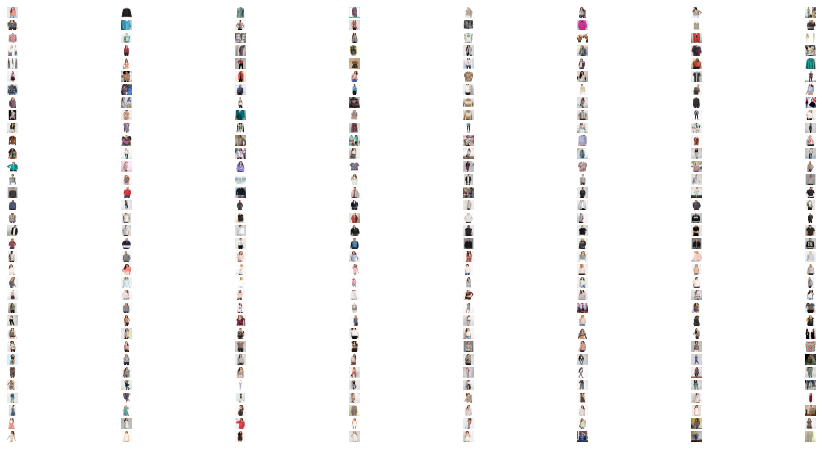

In [8]:
image_paths = glob.glob('images-by-style/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

# Modeling: Compute and Visualize the Style Embeddings

In [9]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 

# Print shapes of the style layers and embeddings
image_tensor = load_image(image_paths[0])
style_tensors = image_to_style(image_tensor)
for k,v in style_tensors.items():
    print(f'Style tensor {k}: {v.shape}')
style_embedding = style_to_vec( style_tensors )
print(f'Style embedding: {style_embedding.shape}')

# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

80134624/80134624 [==============================] - 0s 0us/step
Style tensor block1_conv1: (1, 64, 64)
Style tensor block2_conv1: (1, 128, 128)
Style tensor block3_conv1: (1, 256, 256)
Style embedding: (86016,)


100%|██████████| 275/275 [10:05<00:00,  2.20s/it]


In [10]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


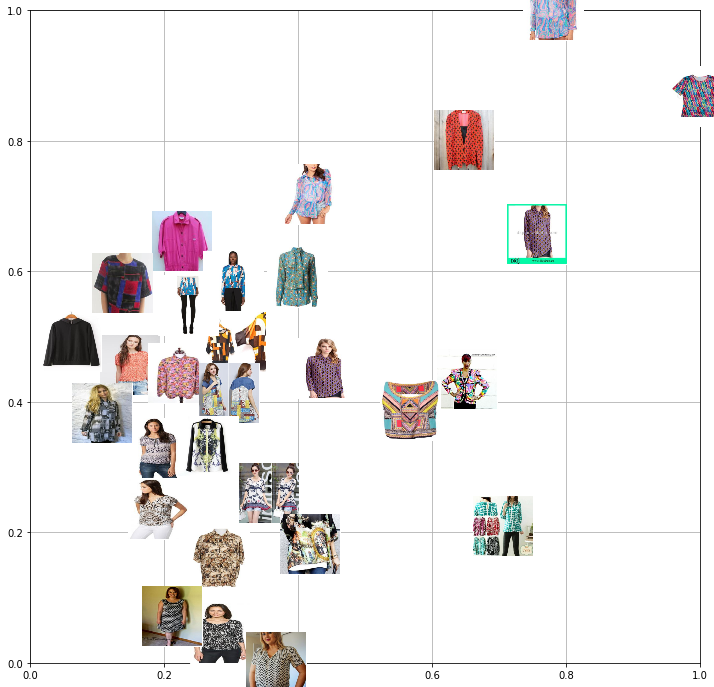

In [11]:
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
def embedding_plot(X, images, thumbnail_sparsity = 0.005, thumbnail_size = 0.3):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))

    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
        shown_images = np.r_[shown_images, [X[i]]]
        thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
        ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=10, random_state=0)
X_tsne = tsne.fit_transform( np.array(list(image_style_embeddings.values())) )
embedding_plot(X_tsne, images=list(images.values()))

# Search in the Embedding Space

In [32]:
def search_by_style(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()

    plt.show()

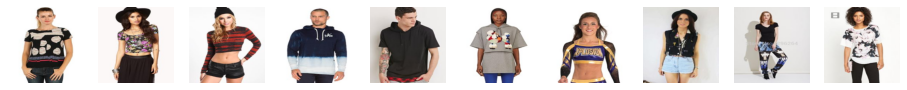

In [33]:
# images mostly match the reference style, although not perfectly
search_by_style(image_style_embeddings, images, 'cutout_back_top_31.jpg')

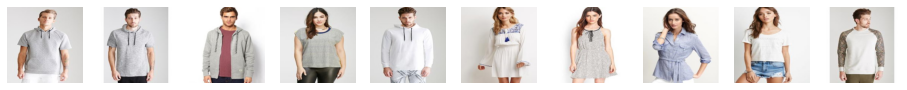

In [34]:
# images mostly match the reference style, although not perfectly
search_by_style(image_style_embeddings, images, 'hoodie_10.jpg')

In [35]:
# Re-defining the above search_by_style function to return list of sorted_neighbours, instead of plotting the images
def search_by_style2(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d
    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]

In [36]:
# images mostly match the reference style, although not perfectly
search_by_style2('cutout_back_top_31.jpg')
# Returns list of images which are closest to the reference image
# Second element of the set in the above returned list gives the distance between the reference image and all other images

[('cutout_back_top_31.jpg', 0),
 ('cutout_back_top_5.jpg', 0.025249183177947998),
 ('sweater_1.jpg', 0.02876138687133789),
 ('hoodie_38.jpg', 0.029463112354278564),
 ('hoodie_11.jpg', 0.03134334087371826),
 ('hoodie_2.jpg', 0.03492271900177002),
 ('cutout_back_top_19.jpg', 0.035301804542541504),
 ('patterned_blouse_52.jpg', 0.03946048021316528),
 ('joggers_8.jpg', 0.03973907232284546),
 ('cutout_back_top_14.jpg', 0.04237323999404907),
 ('patterned_blouse_28.jpg', 0.04425162076950073)]

In [37]:
# images mostly match the reference style, although not perfectly
search_by_style2('hoodie_10.jpg')

[('hoodie_10.jpg', 0),
 ('hoodie_34.jpg', 0.021118521690368652),
 ('hoodie_15.jpg', 0.02214992046356201),
 ('cutout_back_top_21.jpg', 0.02309274673461914),
 ('hoodie_35.jpg', 0.023340225219726562),
 ('henley_dress_10.jpg', 0.024546384811401367),
 ('henley_dress_6.jpg', 0.02512568235397339),
 ('sweater_5.jpg', 0.025950253009796143),
 ('cutout_back_top_16.jpg', 0.027838408946990967),
 ('hoodie_33.jpg', 0.028146803379058838),
 ('hoodie_30.jpg', 0.031099438667297363)]

## Creating a dataframe with all the images in the dataset and their top 10 similar results

In [40]:
# List of all images in the dataset and their top 10 matches based on Cosine Similarity
img_list = [search_by_style2(img) for img in images.keys()]

In [43]:
a = img_list[:11]
a

[[('patterned_blouse_0.jpg', 0),
  ('cutout_back_top_6.jpg', 0.06772720813751221),
  ('patterned_blouse_106.jpg', 0.07784724235534668),
  ('patterned_blouse_65.jpg', 0.08447211980819702),
  ('sweater_26.jpg', 0.08507418632507324),
  ('patterned_blouse_36.jpg', 0.08781987428665161),
  ('cutout_back_top_29.jpg', 0.08838313817977905),
  ('patterned_blouse_74.jpg', 0.09007370471954346),
  ('patterned_blouse_18.jpg', 0.0908697247505188),
  ('joggers_7.jpg', 0.0917811393737793),
  ('sweater_12.jpg', 0.09365212917327881)],
 [('patterned_blouse_2.jpg', 0),
  ('patterned_blouse_85.jpg', 0.032365381717681885),
  ('hoodie_0.jpg', 0.037384867668151855),
  ('hoodie_5.jpg', 0.03819882869720459),
  ('hoodie_16.jpg', 0.04307246208190918),
  ('hoodie_9.jpg', 0.04312163591384888),
  ('patterned_blouse_17.jpg', 0.04383039474487305),
  ('hoodie_38.jpg', 0.04716765880584717),
  ('hoodie_18.jpg', 0.0472259521484375),
  ('hoodie_27.jpg', 0.04753369092941284),
  ('hoodie_21.jpg', 0.04849487543106079)],
 [('pa

In [50]:
import pandas as pd

# Create a dataframe with above results
img_similarity_df = pd.DataFrame(img_list)
# Returning only the first element (i.e. the image name) and storing in the dataframe
img_similarity_df = img_similarity_df.applymap(lambda x: x[0])
img_similarity_df

,0,1,2,3,4,5,6,7,8,9,10
0,patterned_blouse_0.jpg,cutout_back_top_6.jpg,patterned_blouse_106.jpg,patterned_blouse_65.jpg,sweater_26.jpg,patterned_blouse_36.jpg,cutout_back_top_29.jpg,patterned_blouse_74.jpg,patterned_blouse_18.jpg,joggers_7.jpg,sweater_12.jpg
1,patterned_blouse_2.jpg,patterned_blouse_85.jpg,hoodie_0.jpg,hoodie_5.jpg,hoodie_16.jpg,hoodie_9.jpg,patterned_blouse_17.jpg,hoodie_38.jpg,hoodie_18.jpg,hoodie_27.jpg,hoodie_21.jpg
2,patterned_blouse_5.jpg,patterned_blouse_79.jpg,patterned_blouse_68.jpg,patterned_blouse_87.jpg,patterned_blouse_97.jpg,patterned_blouse_24.jpg,patterned_blouse_8.jpg,cutout_back_top_25.jpg,patterned_blouse_106.jpg,patterned_blouse_1.jpg,patterned_blouse_56.jpg
3,patterned_blouse_1.jpg,patterned_blouse_76.jpg,patterned_blouse_5.jpg,patterned_blouse_24.jpg,patterned_blouse_68.jpg,cutout_back_top_25.jpg,patterned_blouse_56.jpg,patterned_blouse_8.jpg,patterned_blouse_87.jpg,patterned_blouse_79.jpg,patterned_blouse_51.jpg
4,patterned_blouse_3.jpg,henley_dress_0.jpg,sweater_11.jpg,sweater_14.jpg,patterned_blouse_101.jpg,sweater_7.jpg,sweater_15.jpg,henley_dress_14.jpg,sweater_4.jpg,sweater_20.jpg,sweater_29.jpg
...,...,...,...,...,...,...,...,...,...,...,...
270,henley_dress_25.jpg,joggers_6.jpg,henley_dress_22.jpg,joggers_13.jpg,patterned_blouse_67.jpg,patterned_blouse_7.jpg,patterned_blouse_31.jpg,cutout_back_top_9.jpg,patterned_blouse_37.jpg,patterned_blouse_32.jpg,patterned_blouse_91.jpg
271,henley_dress_31.jpg,henley_dress_9.jpg,henley_dress_6.jpg,hoodie_10.jpg,henley_dress_10.jpg,hoodie_34.jpg,patterned_blouse_42.jpg,hoodie_30.jpg,patterned_blouse_92.jpg,hoodie_15.jpg,hoodie_33.jpg
272,henley_dress_16.jpg,patterned_blouse_11.jpg,patterned_blouse_94.jpg,patterned_blouse_41.jpg,patterned_blouse_16.jpg,patterned_blouse_6.jpg,patterned_blouse_79.jpg,henley_dress_22.jpg,patterned_blouse_60.jpg,patterned_blouse_81.jpg,joggers_20.jpg
273,henley_dress_13.jpg,henley_dress_29.jpg,patterned_blouse_81.jpg,patterned_blouse_49.jpg,patterned_blouse_23.jpg,patterned_blouse_75.jpg,patterned_blouse_63.jpg,patterned_blouse_67.jpg,cutout_back_top_13.jpg,joggers_20.jpg,patterned_blouse_91.jpg


In [51]:
# Saving the above table into a CSV to use as index for Elasticsearch
img_similarity_df.to_csv('sim_index.csv')